# Automatic Hyperparameter Tuning
Automatic hyperparameter tuning with Optuna library. Refer to the tutorial.
## Step 1: Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
import os

ROOT = os.path.dirname(os.path.abspath("."))
sys.path.append(ROOT)

import torch
import argparse
import os.path as osp
from mmcv import Config
from trademaster.utils import replace_cfg_vals
from trademaster.nets.builder import build_net
from trademaster.environments.builder import build_environment
from trademaster.datasets.builder import build_dataset
from trademaster.agents.builder import build_agent
from trademaster.optimizers.builder import build_optimizer
from trademaster.losses.builder import build_loss
from trademaster.trainers.builder import build_trainer
from trademaster.transition.builder import build_transition
import optuna
from shutil import copyfile, rmtree
import joblib

from trademaster.utils import set_seed
set_seed(2023)

import pandas as pd
from functools import partial
from torch.distributions import Distribution
Distribution.set_default_validate_args(False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Step 2: Load Configs
Load default config from the folder.
Set the flag auto_tuning to True and n_trials as the number of hyperparameter groups wanted to be searched. 

In [2]:
def parse_args(n_trials, algo_type, algo_name, auto_tuning=True):
    parser = argparse.ArgumentParser(description='Download Alpaca Datasets')
    parser.add_argument("--config", default=osp.join(ROOT, "configs", algo_type, algo_name + ".py"),
                        help="download datasets config file path")
    parser.add_argument("--task_name", type=str, default="train")
    parser.add_argument("--auto_tuning", default=auto_tuning, type=bool)
    parser.add_argument("--n_trials", default=n_trials, type=int)
    args, _= parser.parse_known_args()
    return args

## Step 3: Build RL agent, environment and trainer

In [3]:
def trainer_builder(args, sampled_params, algo_name):
    cfg = Config.fromfile(args.config)
    
    # and make replacements as needed
    # cfg.data.data_path = osp.join('data', 'portfolio_management', 'exchange')
    # cfg.data.train_path = osp.join('data', 'portfolio_management', 'exchange', 'train.csv')
    # cfg.data.valid_path = osp.join('data', 'portfolio_management', 'exchange', 'valid.csv')
    # cfg.data.test_path = osp.join('data', 'portfolio_management', 'exchange', 'test.csv')
    # cfg.data.test_dynamic_path = osp.join('data', 'portfolio_management', 'exchange', 'test_labeled_3_24_-0.05_0.05.csv')
    # cfg.data.transaction_cost_pct = 0.003
    cfg.work_dir = osp.join('work_dir', algo_name)
    
    # building dataset
    dataset = build_dataset(cfg)

    train_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="train"))
    valid_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="valid"))
    test_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="test"))

    action_dim = train_environment.action_dim # 29
    state_dim = train_environment.state_dim # 11
    
    agent = None
    
    if algo_name == "portfolio_management_dj30_eiie_eiie_adam_mse":
        input_dim = len(train_environment.tech_indicator_list)
        time_steps = train_environment.time_steps
        cfg.act.update(dict(input_dim=input_dim, time_steps=time_steps))
        cfg.cri.update(dict(input_dim=input_dim, action_dim=action_dim, time_steps=time_steps))
        
        if args.auto_tuning == True:
            lr = sampled_params['lr']
            optimizer_type = sampled_params['optimizer_type']
            act_dims = [sampled_params['act_dims']]
            act_kernel_size = sampled_params['act_kernel_size']
            cri_num_layers = sampled_params['cri_num_layers']
            cri_hidden_size = sampled_params['cri_hidden_size']
            cfg.optimizer.update(dict(lr=lr, type=optimizer_type))
            cfg.optimizer_name = (optimizer_type)
            cfg.act.update(dict(kernel_size=act_kernel_size, dims=act_dims))
            cfg.cri.update(dict(num_layers=cri_num_layers, hidden_size=cri_hidden_size))
        
        act = build_net(cfg.act)
        cri = build_net(cfg.cri)
        act_optimizer = build_optimizer(cfg, default_args=dict(params=act.parameters()))
        cri_optimizer = build_optimizer(cfg, default_args=dict(params=cri.parameters()))     
        criterion = build_loss(cfg)
        transition = build_transition(cfg)
        agent = build_agent(cfg, default_args=dict(action_dim=action_dim,
                                                   state_dim=state_dim,
                                                   time_steps=time_steps,
                                                   act=act,
                                                   cri=cri,
                                                   act_optimizer=act_optimizer,
                                                   cri_optimizer=cri_optimizer,
                                                   criterion=criterion,
                                                   transition=transition,
                                                   device=device))  
            
    if algo_name == "portfolio_management_dj30_investor_imitator_investor_imitator_adam_mse":        
        input_dim = train_environment.observation_space.shape[1]
        cfg.act.update(dict(input_dim=input_dim, output_dim=action_dim))
        
        if args.auto_tuning == True:
            lr = sampled_params['lr']
            optimizer_type = sampled_params['optimizer_type']
            act_dims = [sampled_params['act_dims']]
            cfg.optimizer.update(dict(lr=lr, type=optimizer_type))
            cfg.optimizer_name = (optimizer_type)
            cfg.act.update(dict(dims=act_dims))
                    
        act = build_net(cfg.act)
        act_optimizer = build_optimizer(cfg, default_args=dict(params=act.parameters()))  
        criterion = build_loss(cfg)    
        agent = build_agent(cfg, default_args=dict(action_dim=action_dim,
                                            state_dim=state_dim,
                                            act=act,
                                            act_optimizer=act_optimizer,
                                            criterion=criterion,
                                            device=device))
            
    trainer = build_trainer(cfg, default_args=dict(train_environment=train_environment,valid_environment=valid_environment,test_environment=test_environment,agent=agent,device=device))             
    print(cfg)  
    return trainer

## Step 4: Sample hyperparameters using Optuna
Optuna library provides functions to sample different types of hyperparameters. 

In [4]:
def sample_params(trial: optuna.Trial, algo_name):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    # optimizer_type = trial.suggest_categorical("optimizer_type", ["Adam", "AdamW", "Adagrad", "Adadelta", "SGD"])
    optimizer_type = trial.suggest_categorical("optimizer_type", ["Adam", "AdamW", "Adadelta", "SGD"])
    act_dims = trial.suggest_int("act_dims", 16, 256, step=2, log=False)
    trial_number = trial.number
    
    sampled_params = None
    
    if algo_name == "portfolio_management_dj30_eiie_eiie_adam_mse":
        act_kernel_size = trial.suggest_categorical("act_kernel_size", [3,5,7])
        cri_num_layers = trial.suggest_int("cri_num_layers", 1, 5, step=1, log=False)
        cri_hidden_size = trial.suggest_int("cri_hidden_size", 16, 64, step=2, log=False)
        sampled_params = dict(lr=lr, optimizer_type=optimizer_type, act_dims=act_dims, 
                          act_kernel_size=act_kernel_size, cri_num_layers=cri_num_layers, 
                          cri_hidden_size=cri_hidden_size, trial_number=trial_number)
        
    if algo_name == "portfolio_management_dj30_investor_imitator_investor_imitator_adam_mse":
        # act_type = trial.suggest_categorical("act_type", ["MLPReg","MLPCls"])
        sampled_params = dict(lr=lr, optimizer_type=optimizer_type, act_dims=act_dims, 
                        trial_number=trial_number)

    return sampled_params

## Step 5: Define objective function of the optimization procedure
Optuna tries to find the best hyperparameter pair by optimizing a specific objective function. 
In this tutorial, the original training procedure is repeated, and the sum of episode reward on valid dataset is used as the objective function. 

In [5]:
def objective(trial: optuna.Trial, n_trials, algo_type, algo_name, cfg, metrics="Total Return") -> float:
    args = parse_args(n_trials, algo_type, algo_name)
    sampled_params = sample_params(trial, algo_name=algo_name)
    trainer = trainer_builder(args, sampled_params, algo_name=algo_name)
    trainer.train_and_valid()
    trainer.test()
    
    # we need to rename the best model for this trial
    best_path = os.path.join(ROOT, cfg.work_dir, "checkpoints", "best.pth")
    trial_best_path = os.path.join(ROOT, cfg.work_dir, "checkpoints", "trial-{:05d}.pth".format(trial.number))
    os.rename(best_path, trial_best_path) 
    
    # retrive test results
    df_return = trainer.test_environment.save_portfolio_return_memory()
    df_assets = trainer.test_environment.save_asset_memory()
    assets = df_assets["total assets"].values
    daily_return = df_return.daily_return.values
    df = pd.DataFrame()
    df["daily_return"] = daily_return
    df["total assets"] = assets

    tr, sharpe_ratio, vol, mdd, cr, sor = trainer.test_environment.evaualte(df)
    # stats = {
    #     "Total Return": ["{:04f}%".format(tr * 100)],
    #     "Sharp Ratio": ["{:04f}".format(sharpe_ratio)],
    #     "Volatility": ["{:04f}%".format(vol* 100)],
    #     "Max Drawdown": ["{:04f}%".format(mdd* 100)],
    #     "Calmar Ratio": ["{:04f}".format(cr)],
    #     "Sortino Ratio": ["{:04f}".format(sor)],
    # }
    stats = {
        "Total Return": tr,
        "Sharp Ratio": sharpe_ratio,
        "Volatility": vol,
        "Max Drawdown": mdd,
        "Calmar Ratio": cr,
        "Sortino Ratio": sor,
    }
    return stats[metrics]

## Step 6: Run the whole tuning procedure
Due to the fact that the original training pipeline will be run for n_trials of times, it might take time to be finished. Please use smaller n_trials to reduce time for tuning.

In [6]:
def finetune_hyperparameters(n_trials, algo_type, algo_name, metrics="Total Return"):
    args = parse_args(n_trials=n_trials, algo_type=algo_type, algo_name=algo_name)
    cfg = Config.fromfile(args.config)
    cfg.work_dir = osp.join('work_dir', algo_name)
    
    # restart previous work
    if os.path.isdir(os.path.join(ROOT, cfg.work_dir, "checkpoints")):
        rmtree(os.path.join(ROOT, cfg.work_dir, "checkpoints"))

    if args.task_name.startswith("train"):
        study = optuna.create_study(direction="maximize")
        study.optimize(partial(objective, n_trials=n_trials, algo_type=algo_type, algo_name=algo_name, cfg=cfg, metrics="Total Return"), n_trials=args.n_trials)
        print("Best trial:")
        trial = study.best_trial
        print("  Value: ", trial.value)
        print("  Params: ")
        for key, value in trial.params.items():
            print("    {}: {}".format(key, value))
        print("  Best trial number: ", trial.number)
        best_model_path = os.path.join(ROOT, cfg.work_dir, "checkpoints", "trial-{:05d}.pth".format(trial.number))
        # best.pth for test, _best.pth for record
        copyfile(best_model_path, os.path.join(ROOT, cfg.work_dir, "checkpoints", "best.pth"))
        copyfile(best_model_path, os.path.join(ROOT, cfg.work_dir, algo_name + "_best.pth"))
        joblib.dump(study, os.path.join(ROOT, cfg.work_dir, algo_name + "_auto_tuning.pkl"))
        trainer = trainer_builder(args, sampled_params=sample_params(study.best_trial, algo_name=algo_name), algo_name=algo_name)
        trainer.test()
        print("train end")
    elif args.task_name.startswith("test"):
        study = joblib.load(os.path.join(ROOT, cfg.work_dir, algo_name + "auto_tuning.pkl"))
        trainer = trainer_builder(args, sampled_params=sample_params(study.best_trial, algo_name=algo_name), algo_name=algo_name)
        trainer.test()
        print("test end")

# EIIE

In [7]:
args = parse_args(n_trials=15, 
                  algo_type="portfolio_management", 
                  algo_name="portfolio_management_dj30_eiie_eiie_adam_mse")
cfg = Config.fromfile(args.config)

# default configurations
for key in cfg:
  print(f"{key}: {cfg[key]}")

data: {'type': 'PortfolioManagementDataset', 'data_path': 'data/portfolio_management/dj30', 'train_path': 'data/portfolio_management/dj30/train.csv', 'valid_path': 'data/portfolio_management/dj30/valid.csv', 'test_path': 'data/portfolio_management/dj30/test.csv', 'tech_indicator_list': ['zopen', 'zhigh', 'zlow', 'zadjcp', 'zclose', 'zd_5', 'zd_10', 'zd_15', 'zd_20', 'zd_25', 'zd_30'], 'length_day': 10, 'initial_amount': 100000, 'transaction_cost_pct': 0.001, 'test_dynamic_path': 'data/portfolio_management/dj30/test_with_label.csv'}
environment: {'type': 'PortfolioManagementEIIEEnvironment'}
agent: {'type': 'PortfolioManagementEIIE', 'memory_capacity': 1000, 'gamma': 0.99, 'policy_update_frequency': 500}
trainer: {'type': 'PortfolioManagementEIIETrainer', 'epochs': 2, 'work_dir': 'work_dir/portfolio_management_dj30_eiie_eiie_adam_mse', 'if_remove': False}
loss: {'type': 'MSELoss'}
optimizer: {'type': 'Adam', 'lr': 0.001}
act: {'type': 'EIIEConv', 'input_dim': None, 'output_dim': 1, 'tim

In [8]:
# finetune_hyperparameters(n_trials=15, 
#                   algo_type="portfolio_management", 
#                   algo_name="portfolio_management_dj30_eiie_eiie_adam_mse")

# IMIT

In [9]:
args = parse_args(n_trials=5, 
                  algo_type="portfolio_management", 
                  algo_name="portfolio_management_dj30_investor_imitator_investor_imitator_adam_mse")
cfg = Config.fromfile(args.config)

# default configurations
for key in cfg:
  print(f"{key}: {cfg[key]}")

data: {'type': 'PortfolioManagementDataset', 'data_path': 'data/portfolio_management/dj30', 'train_path': 'data/portfolio_management/dj30/train.csv', 'valid_path': 'data/portfolio_management/dj30/valid.csv', 'test_path': 'data/portfolio_management/dj30/test.csv', 'tech_indicator_list': ['high', 'low', 'open', 'close', 'adjcp', 'zopen', 'zhigh', 'zlow', 'zadjcp', 'zclose', 'zd_5', 'zd_10', 'zd_15', 'zd_20', 'zd_25', 'zd_30'], 'length_day': 10, 'initial_amount': 100000, 'transaction_cost_pct': 0.0001, 'test_dynamic_path': 'data/portfolio_management/dj30/test_with_label.csv'}
environment: {'type': 'PortfolioManagementInvestorImitatorEnvironment'}
agent: {'type': 'PortfolioManagementInvestorImitator', 'memory_capacity': 1000, 'gamma': 0.99, 'policy_update_frequency': 500}
trainer: {'type': 'PortfolioManagementInvestorImitatorTrainer', 'epochs': 10, 'work_dir': 'work_dir/portfolio_management_dj30_investor_imitator_investor_imitator_adam_mse', 'if_remove': False}
loss: {'type': 'MSELoss'}
op

Config (path: c:\Users\MatthewWang\Projects\trademaster\trademaster-nyu\configs\portfolio_management\portfolio_management_dj30_investor_imitator_investor_imitator_adam_mse.py): {'data': {'type': 'PortfolioManagementDataset', 'data_path': 'data/portfolio_management/dj30', 'train_path': 'data/portfolio_management/dj30/train.csv', 'valid_path': 'data/portfolio_management/dj30/valid.csv', 'test_path': 'data/portfolio_management/dj30/test.csv', 'tech_indicator_list': ['high', 'low', 'open', 'close', 'adjcp', 'zopen', 'zhigh', 'zlow', 'zadjcp', 'zclose', 'zd_5', 'zd_10', 'zd_15', 'zd_20', 'zd_25', 'zd_30'], 'length_day': 10, 'initial_amount': 100000, 'transaction_cost_pct': 0.0001, 'test_dynamic_path': 'data/portfolio_management/dj30/test_with_label.csv'}, 'environment': {'type': 'PortfolioManagementInvestorImitatorEnvironment'}, 'agent': {'type': 'PortfolioManagementInvestorImitator', 'memory_capacity': 1000, 'gamma': 0.99, 'policy_update_frequency': 500}, 'trainer': {'type': 'PortfolioMana

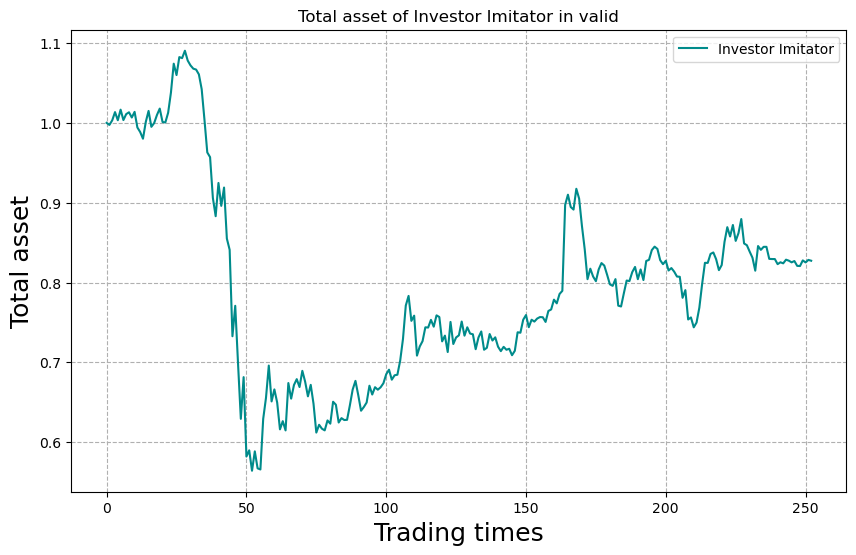

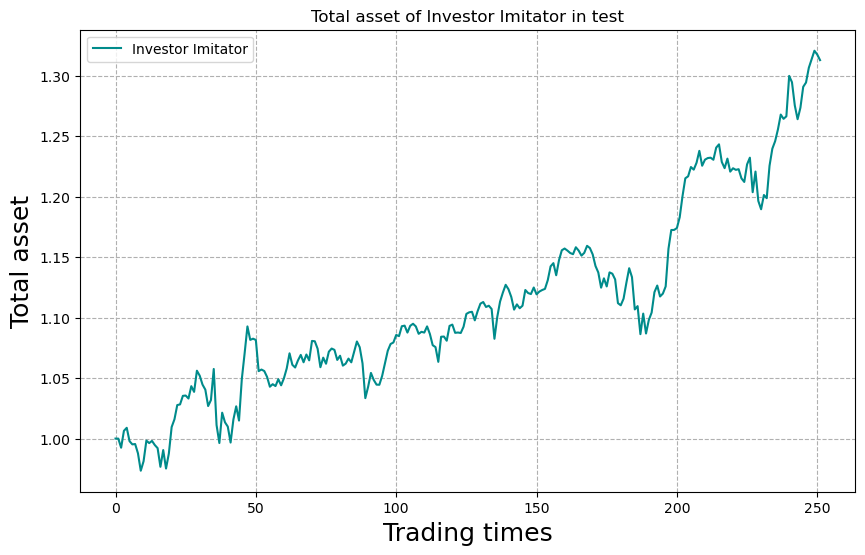

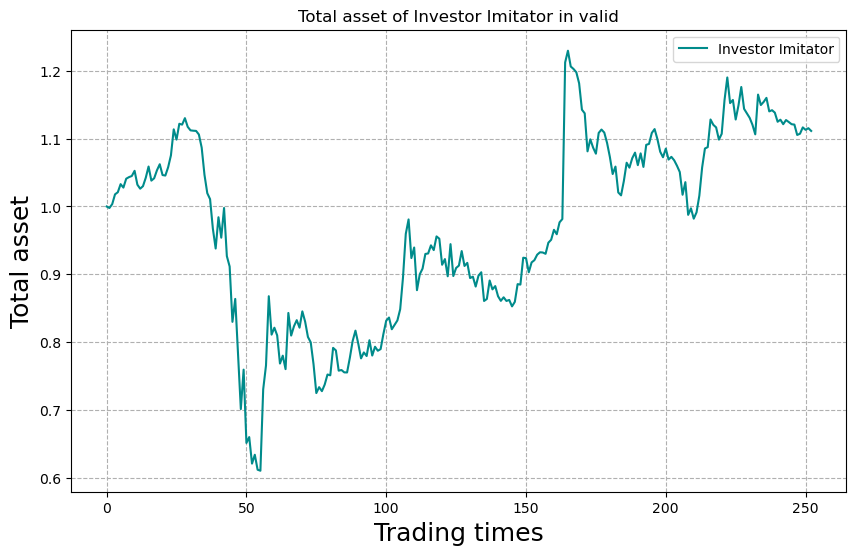

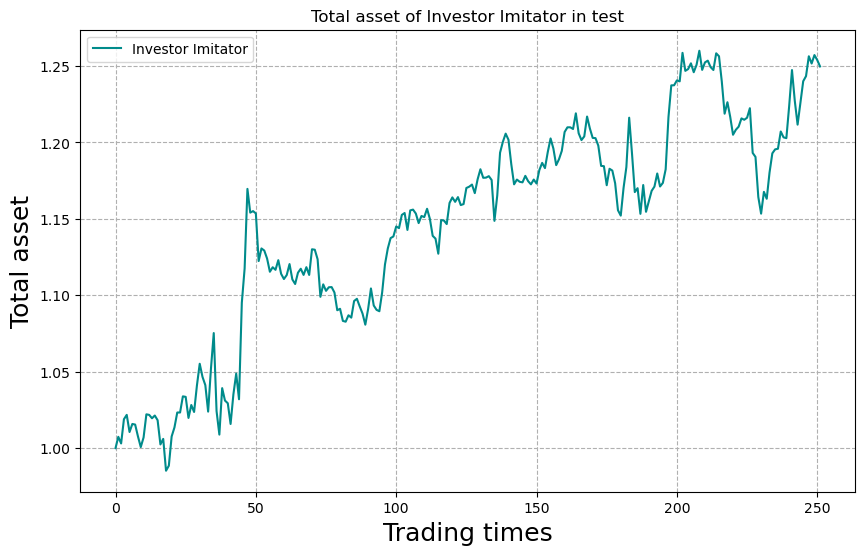

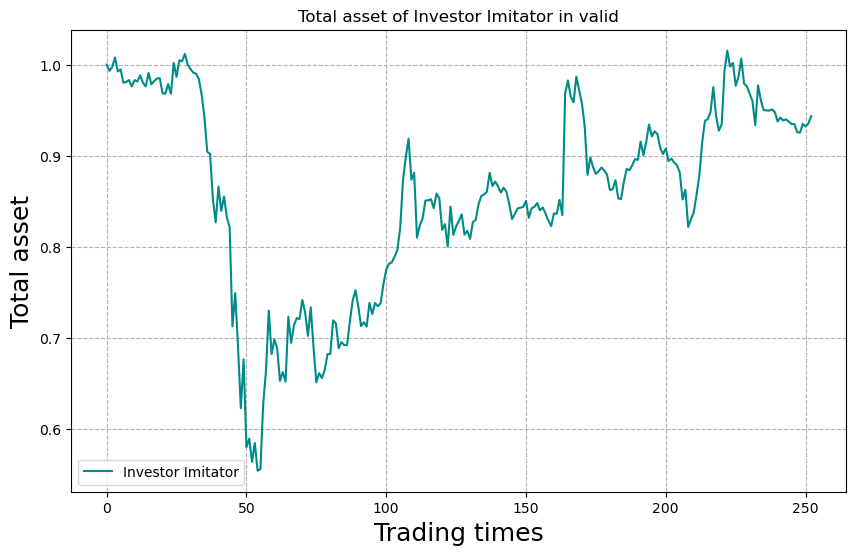

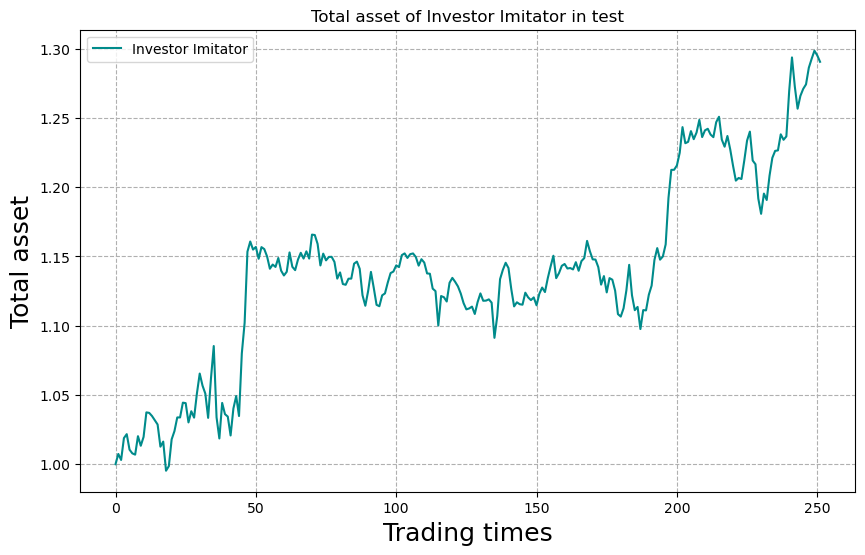

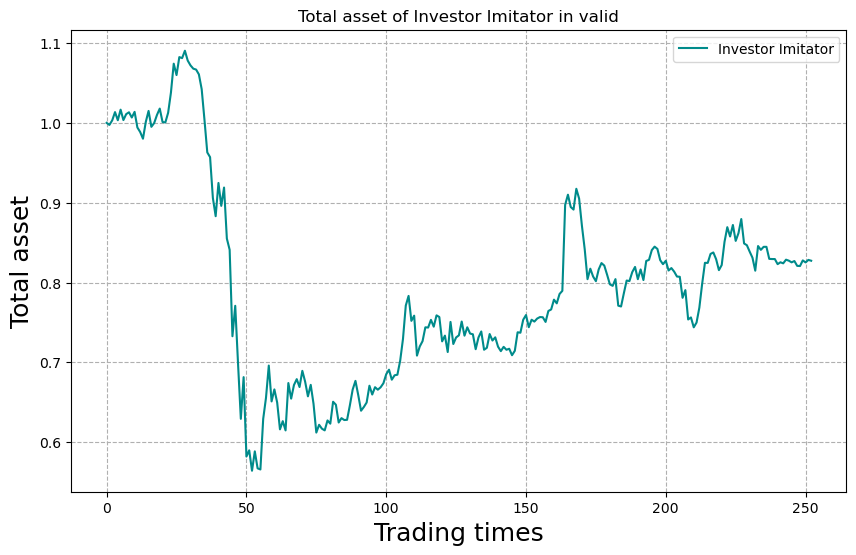

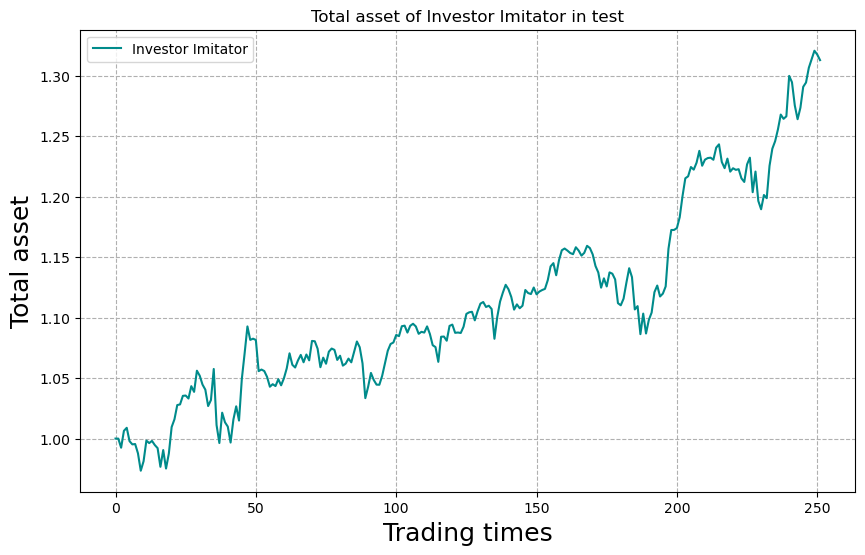

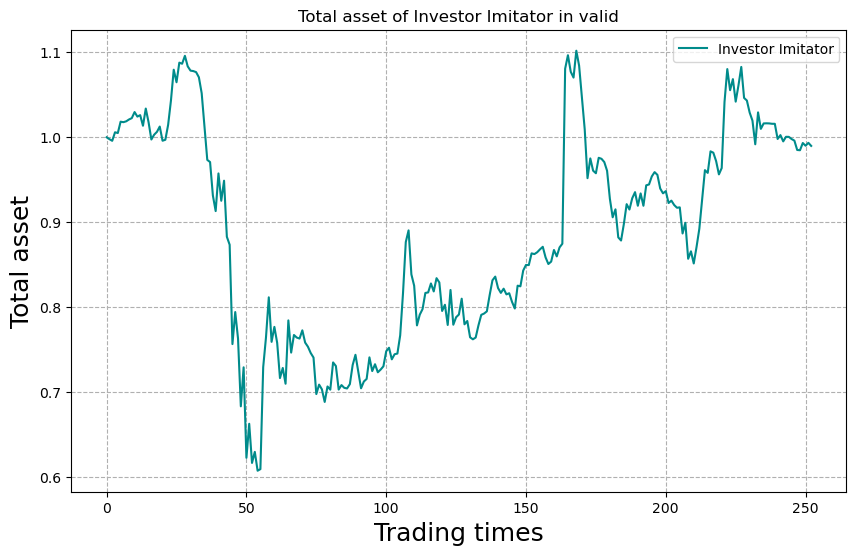

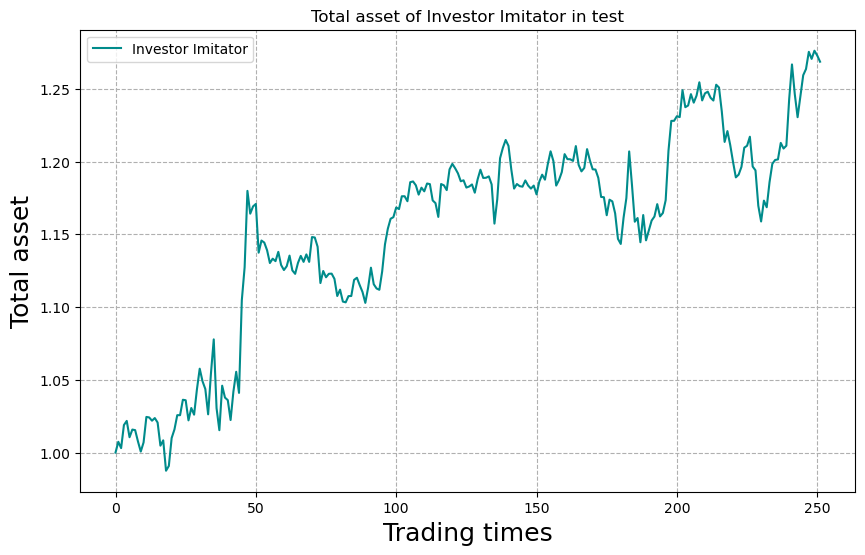

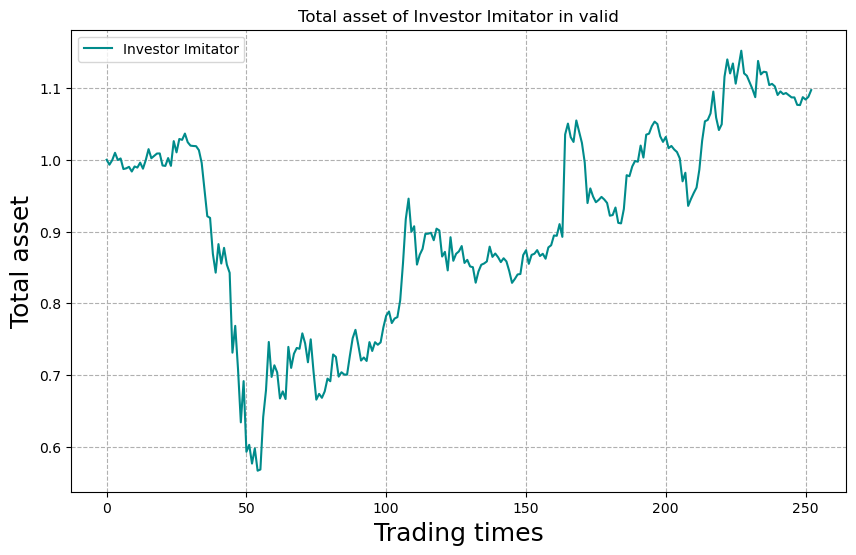

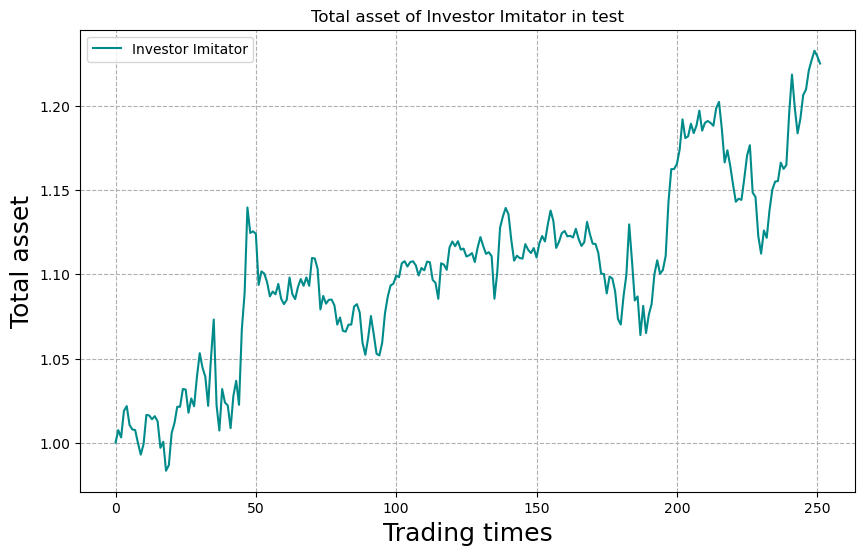

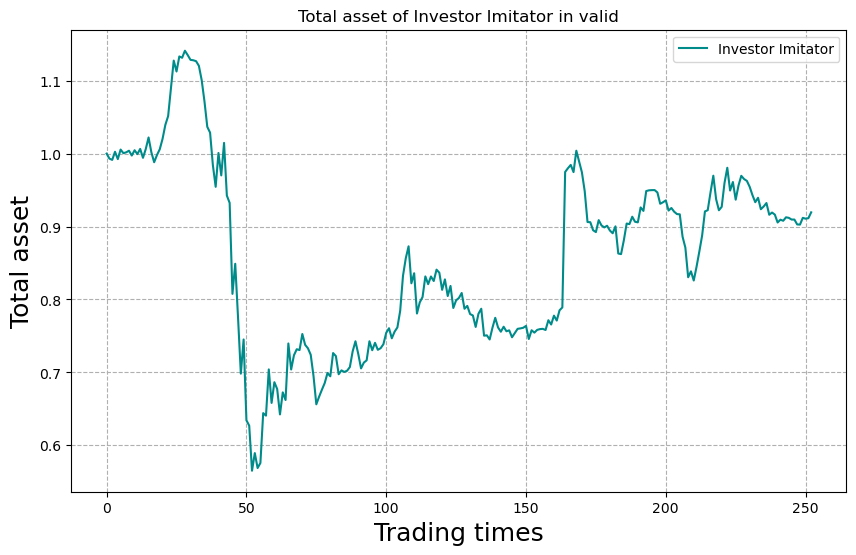

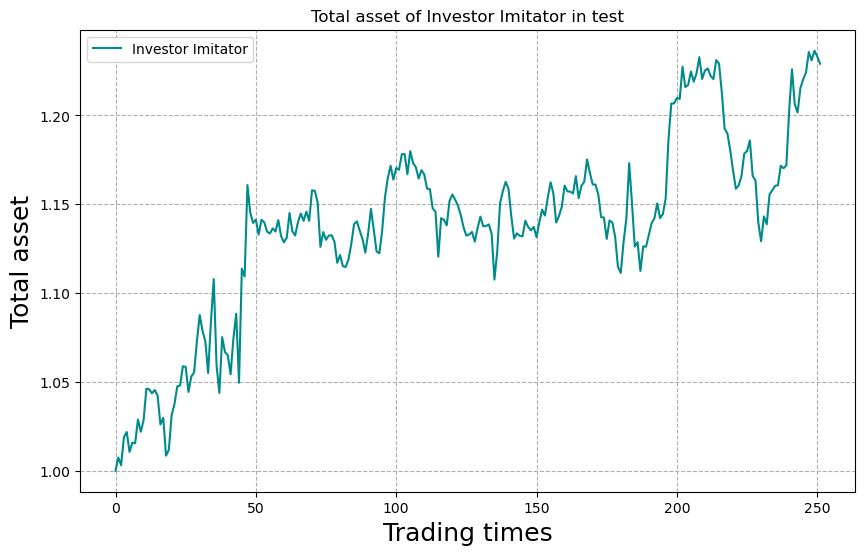

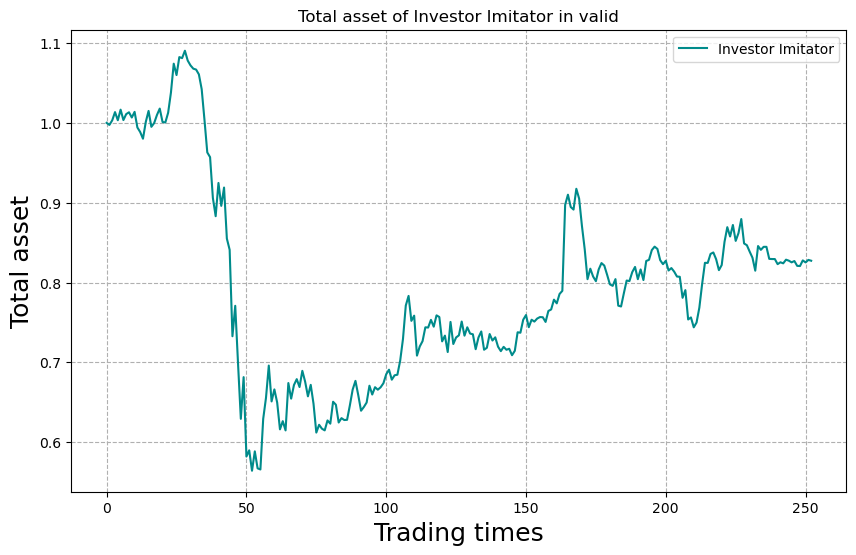

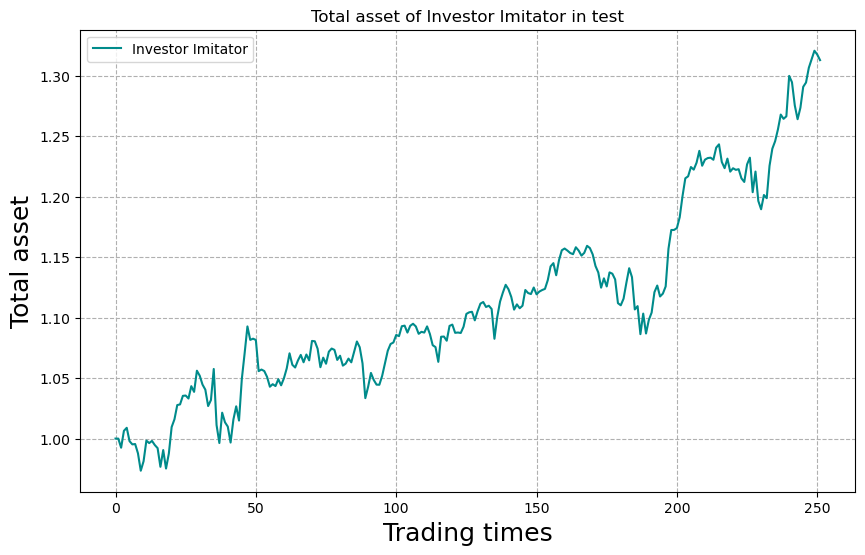

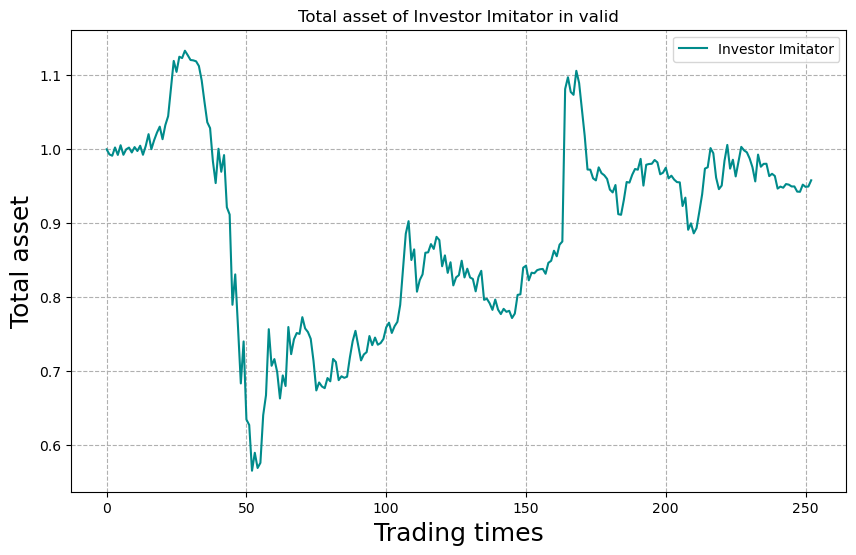

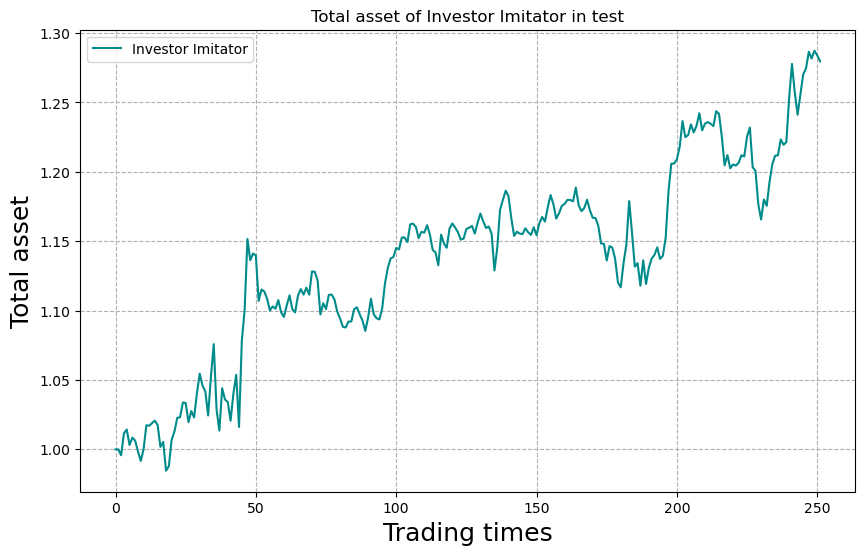

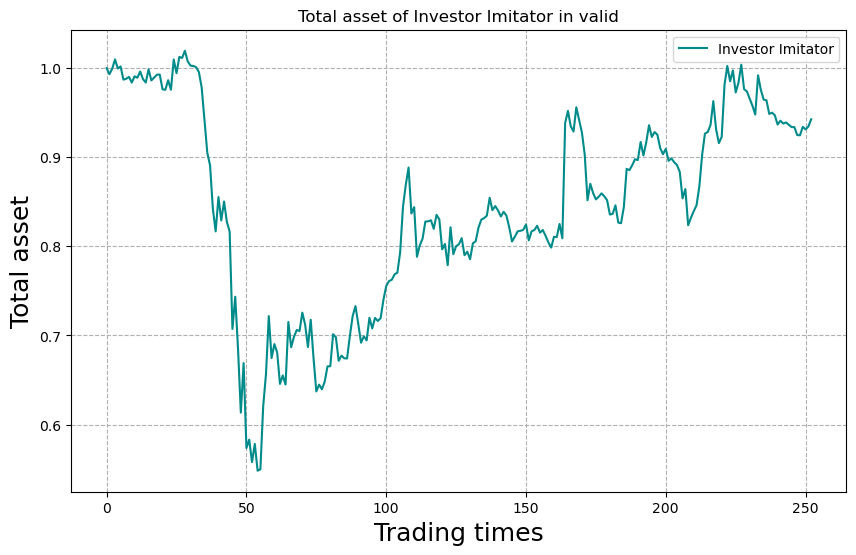

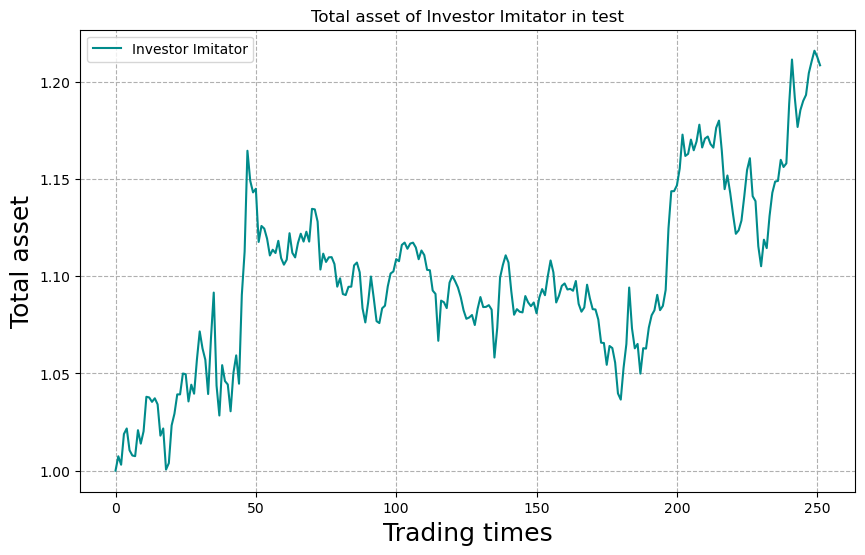

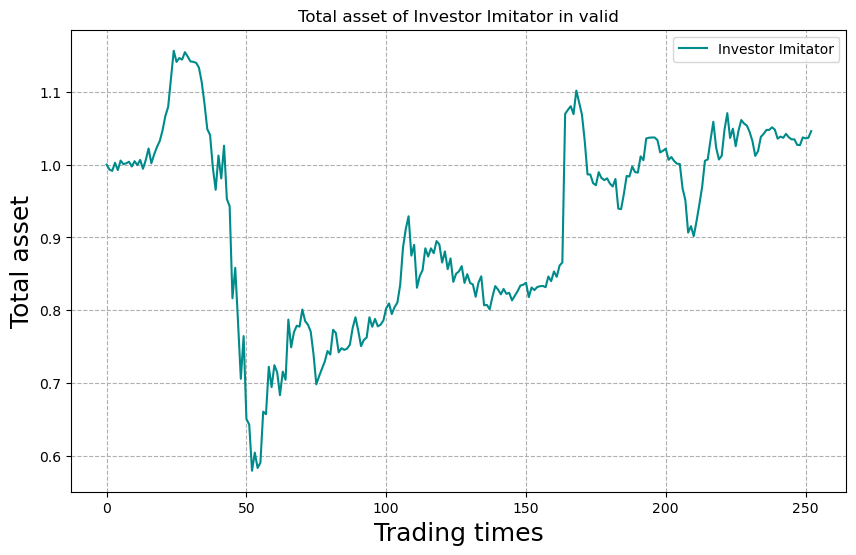

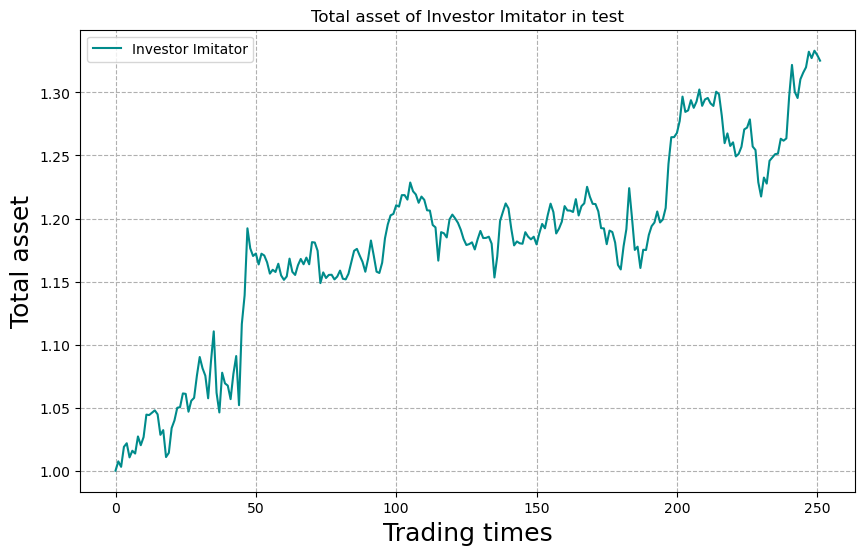

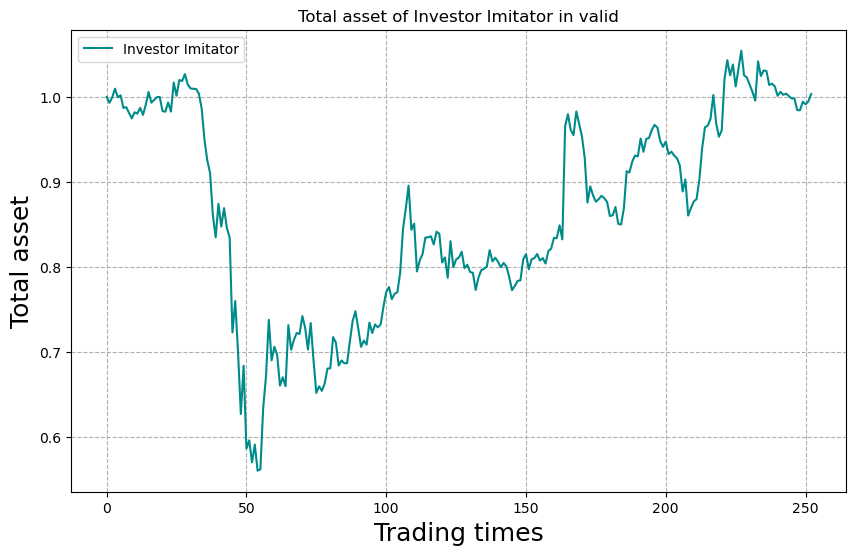

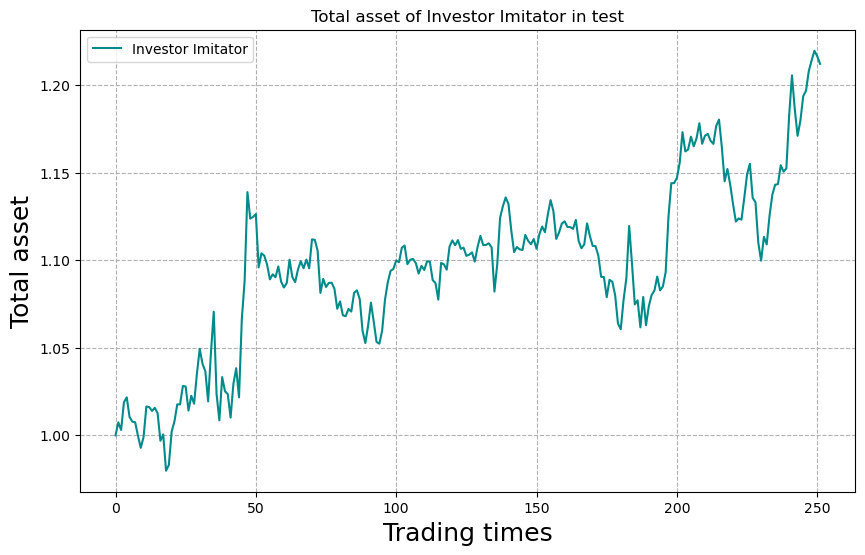

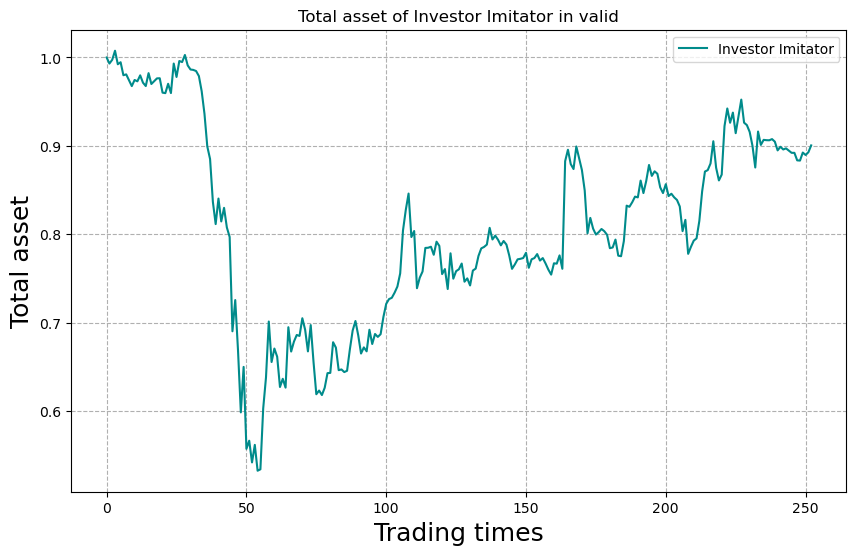

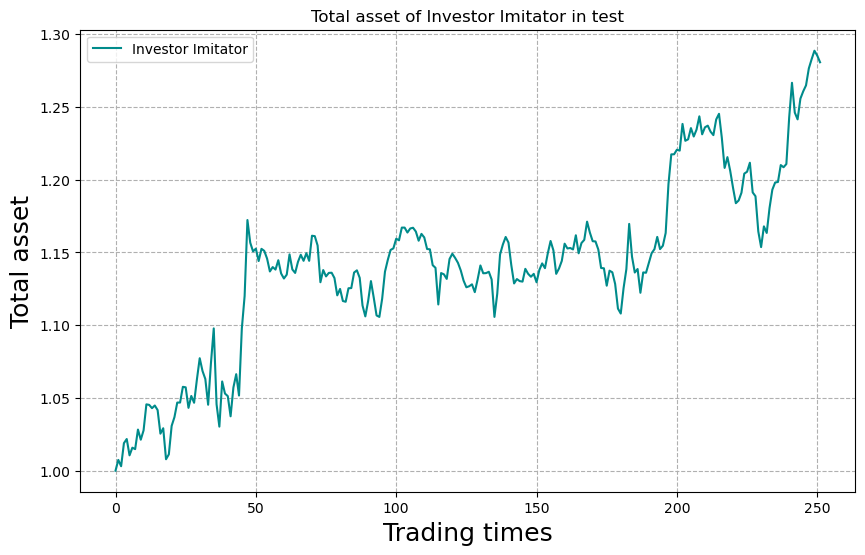

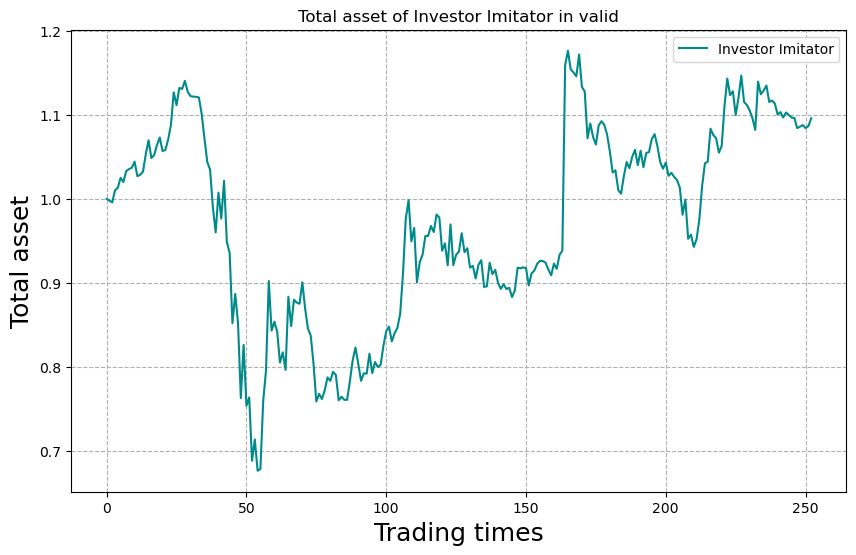

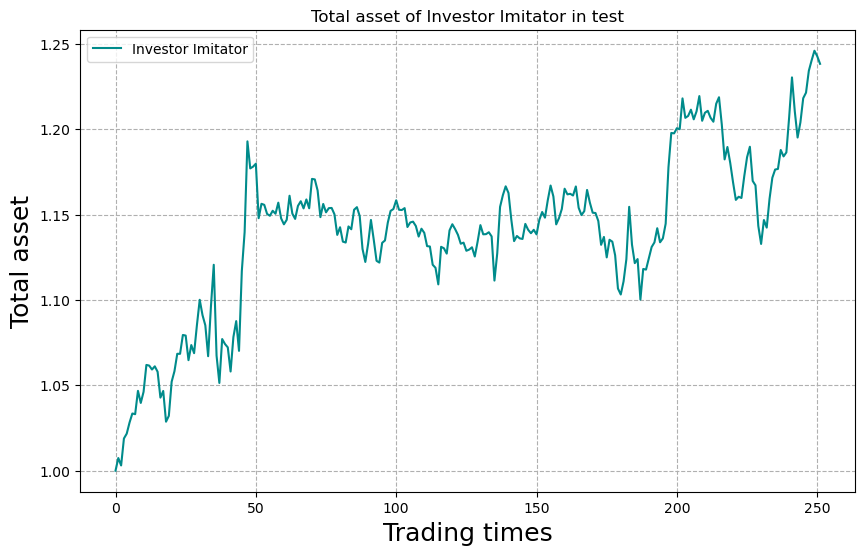

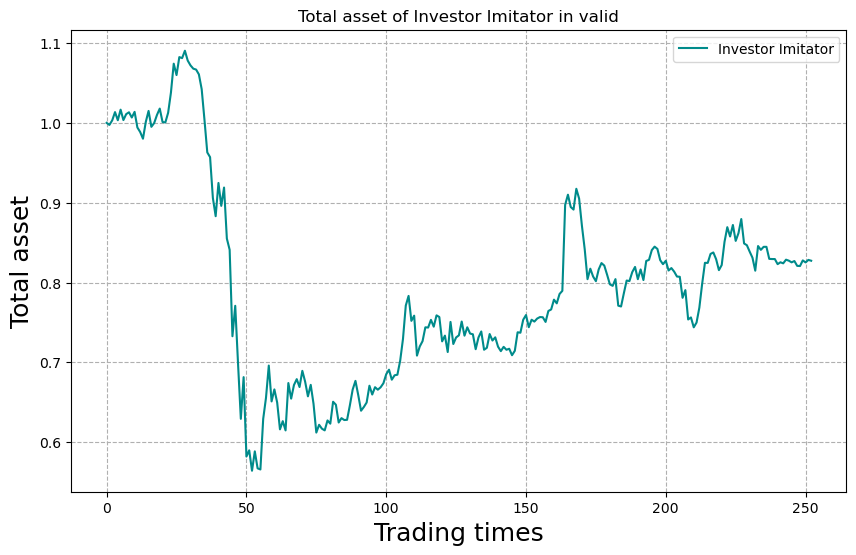

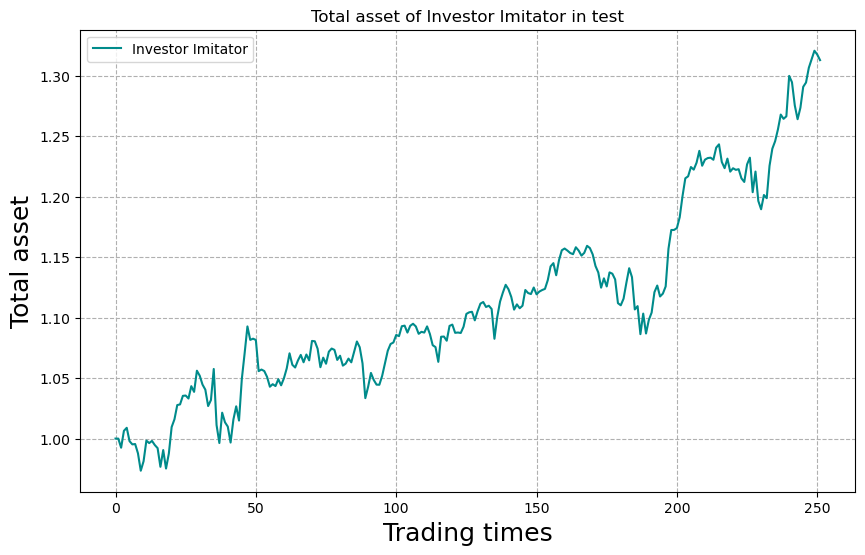

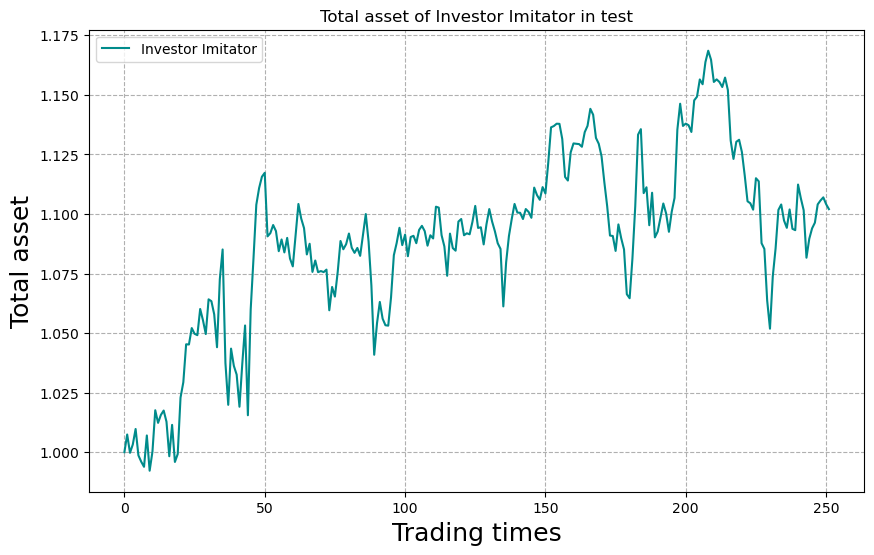

In [10]:
finetune_hyperparameters(n_trials=15, 
                         algo_type="portfolio_management", 
                         algo_name="portfolio_management_dj30_investor_imitator_investor_imitator_adam_mse", 
                         metrics="Total Return")